In [17]:
import tensorflow as tf
from tensorflow.keras import Model,layers
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
import numpy as np
from PIL import Image
from pathlib import Path
import os
import pandas as pd
import matplotlib.pyplot as plt

In [18]:
#Loading images from data
# WIN path
#PATH = "C:/Users/Lenovo/Desktop/AI/AI_Project/data/"
# Linux path
PATH = "/home/changsmarter/Desktop/myAI_Project/data_4500/"
data_dir = Path(PATH)
image_num = len(list(data_dir.glob('*/*/*.jpg')))
image_csv = pd.read_csv(PATH+'RAW_DATA_4500_6_class.csv')
CLASS_NAME = image_csv['Finding Labels'].unique()
print(image_num)
print(CLASS_NAME)

22648
['No Finding' 'TB' 'Heart' 'CA Lung' 'Intra' 'Extra']


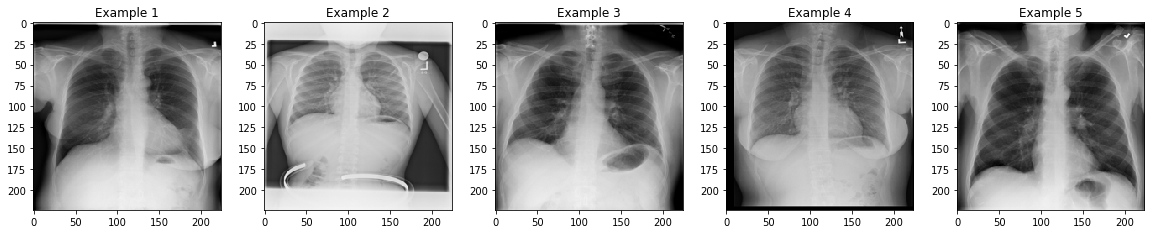

In [19]:
example_NoF = list(data_dir.glob('train/No Finding/*.jpg'))
i = 1
plt.figure(figsize=(20,20))
for n in example_NoF[:5]:
    ex = Image.open(n)
    ex_ar = np.asarray(ex)
    plt.subplot(5,5,i)
    word = "Example "+ str(i)
    plt.title(word)
    plt.imshow(ex_ar)
    i+=1

In [20]:
#Preproccsing image data into ImageDataGenerator
my_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
BATCH_SIZE = 32
IMG_WIDTH = 224
IMG_HEIGHT = 224
TRAIN_PATH = PATH + "/train/"
TEST_PATH = PATH + "/test/"

#This will be my train_set . 
data_gen_train = my_generator.flow_from_directory(directory=TRAIN_PATH,
                                                  batch_size=BATCH_SIZE,
                                                  shuffle=True,
                                                  target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                  classes = list(CLASS_NAME))
#This will be my test_set . 
data_gen_test = my_generator.flow_from_directory(directory=TEST_PATH,
                                                 batch_size=BATCH_SIZE,
                                                 shuffle=True,
                                                 target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                 classes = list(CLASS_NAME))

x_train,y_train = next(data_gen_train)
x_test,y_test = next(data_gen_test)
TRAIN_IMG = 18118
TEST_IMG = 4530

Found 18118 images belonging to 6 classes.
Found 4530 images belonging to 6 classes.


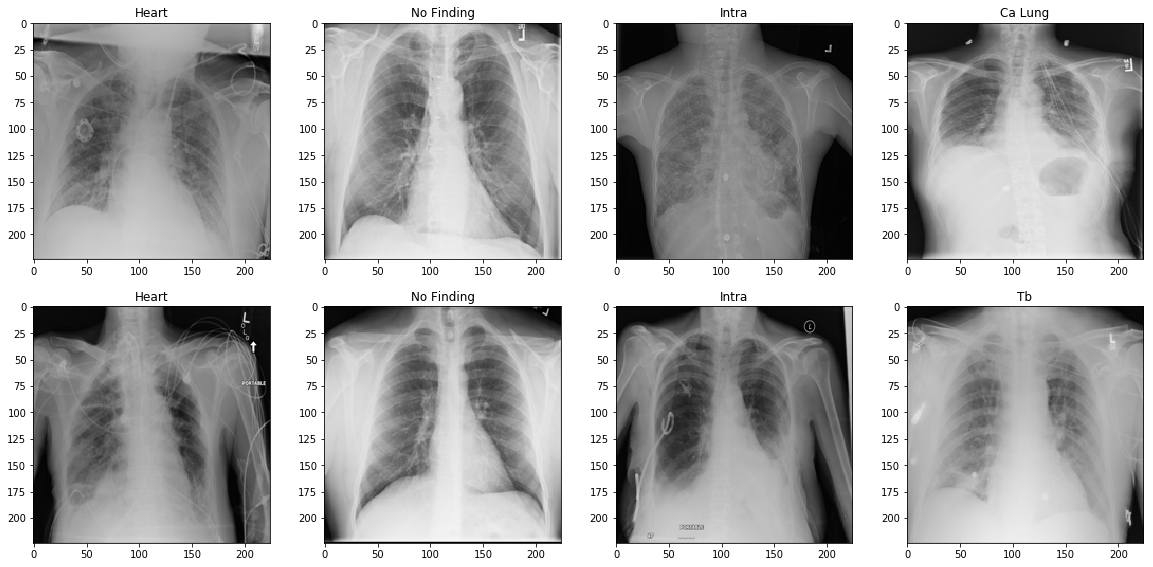

In [21]:
plt.figure(figsize=(20,20))
for n in range(8):
    plt.subplot(4,4,n+1)
    plt.title(CLASS_NAME[y_train[n]==1][0].title())
    plt.imshow(x_train[n])

In [22]:
#Try to load InceptionV3
myInception = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet',input_shape=(224,224,3),classes=6)
for layer in myInception.layers:
    layer.trainable = False

In [23]:
#Add layers configuration suitable for our model
#This is THE endgame for our project . Carefully review your stradigies 
# Current layers stacking is Awful . Inaccurate with fake accuracy

out = myInception.output
out = layers.GlobalAveragePooling2D()(out)
out = layers.Dense(1024,activation='relu')(out)
#out = layers.Dense(512,activation='relu')(out)
#out = layers.Dense(64,activation='relu')(out)
#out = layers.Dropout(0.2)(out)
out = layers.Dense(6,activation='softmax')(out)

myModel = Model(myInception.input,out)

In [26]:
#myModel.summary()
#Callback function when my model hit my max ACC
myEarly = EarlyStopping(monitor='val_loss',patience=2)
myCheckpoint = ModelCheckpoint('myModel_Check_4.hdf5',monitor='val_loss')

In [27]:
myModel.compile(loss='categorical_crossentropy',
                    optimizer='adamax',metrics=['accuracy'])

In [28]:
#Try to fit data into our model
STEP_PER_EPOCH = np.ceil(TRAIN_IMG/BATCH_SIZE)
session = myModel.fit_generator(data_gen_train,
                               validation_data=data_gen_test,
                               epochs = 100,
                               steps_per_epoch=STEP_PER_EPOCH,
                               validation_steps = 30,
                               verbose = 1,
                               callbacks=[myEarly,myCheckpoint])

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 567.0 steps, validate for 30 steps
567/567 [==============================] - 61s 107ms/step - loss: 1.5801 - accuracy: 0.3203 - val_loss: 1.6354 - val_accuracy: 0.2760


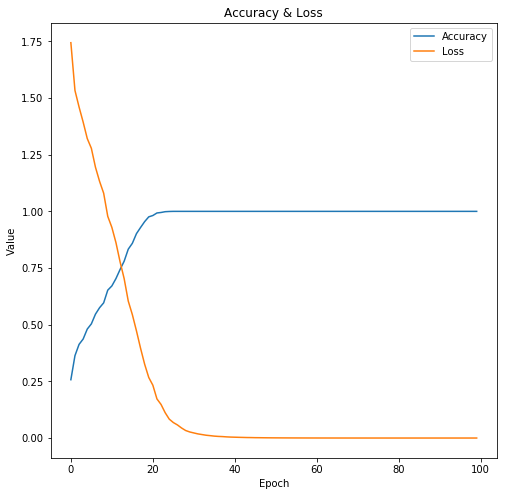

In [78]:
plt.figure(figsize=(8,8))
plt.plot(session.history['accuracy'])
plt.plot(session.history['loss'])
plt.title('Accuracy & Loss')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(['Accuracy','Loss'])
plt.savefig("Third Run.png")
plt.show()

In [71]:
STEP_PER_EPOCH = np.ceil(1022/32)
test_session = myModel.predict_generator(data_gen_test,STEP_PER_EPOCH)

Instructions for updating:
Please use Model.predict, which supports generators.


In [74]:
test_session

array([[8.4299554e-09, 9.9883181e-01, 9.9740501e-14, 3.5441233e-05,
        1.1164999e-03, 1.6216434e-05],
       [1.8901608e-14, 6.7114957e-02, 1.1219877e-09, 1.0633617e-08,
        9.3288499e-01, 7.3802639e-08],
       [9.8721078e-04, 7.4976557e-01, 1.0757882e-10, 2.4877843e-01,
        2.7755666e-05, 4.4107452e-04],
       ...,
       [6.8605920e-12, 9.5473303e-11, 2.5962007e-03, 1.9282736e-01,
        1.7397077e-04, 8.0440247e-01],
       [2.7457770e-11, 1.4471760e-12, 8.1227112e-01, 1.8772882e-01,
        1.4016609e-13, 6.0799884e-08],
       [5.6210760e-09, 7.9323745e-01, 5.1039844e-03, 1.7326383e-05,
        6.4618193e-04, 2.0099500e-01]], dtype=float32)